# 4. Deployment-job-serverless

In [5]:
install_needed = True
# install_needed = False

In [6]:
%%bash
#!/bin/bash

DAEMON_PATH="/etc/docker"
MEMORY_SIZE=10G

FLAG=$(cat $DAEMON_PATH/daemon.json | jq 'has("data-root")')
# echo $FLAG

if [ "$FLAG" == true ]; then
    echo "Already revised"
else
    echo "Add data-root and default-shm-size=$MEMORY_SIZE"
    sudo cp $DAEMON_PATH/daemon.json $DAEMON_PATH/daemon.json.bak
    sudo cat $DAEMON_PATH/daemon.json.bak | jq '. += {"data-root":"/home/ec2-user/SageMaker/.container/docker","default-shm-size":"'$MEMORY_SIZE'"}' | sudo tee $DAEMON_PATH/daemon.json > /dev/null
    sudo service docker restart
    echo "Docker Restart"
fi

sudo curl -L "https://github.com/docker/compose/releases/download/v2.7.0/docker-compose-$(uname -s)-$(uname -m)" -o /usr/local/bin/docker-compose
sudo chmod +x /usr/local/bin/docker-compose

Already revised


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 24.5M  100 24.5M    0     0  45.2M      0 --:--:-- --:--:-- --:--:-- 52.4M


In [7]:
import sys
import IPython

if install_needed:
    print("installing deps and restarting kernel")
    !{sys.executable} -m pip install --upgrade pip --quiet
    !{sys.executable} -m pip install -U sagemaker huggingface_hub transformers --quiet
    IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel


# Start

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sagemaker
import huggingface_hub
from pathlib import Path
from time import strftime

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer
)
import torch


source_dir = f"{Path.cwd()}/src"
os.makedirs(source_dir, exist_ok=True)

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
prefix = "240929-deploy-owl-vit"

role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
os.environ['HF_DATASETS_CACHE'] = '/home/ec2-user/SageMaker/.cache'
os.environ['HF_CACHE_HOME'] = '/home/ec2-user/SageMaker/.cache'
os.environ['HUGGINGFACE_HUB_CACHE'] = '/home/ec2-user/SageMaker/.cache'
# os.environ['TRANSFORMERS_HOME'] = '/home/ec2-user/SageMaker/.cache'
# os.environ['HF_HOME'] = '/home/ec2-user/SageMaker/.cache'

In [4]:
test_model_id = 'google/owlvit-base-patch32'

<br>

## [**Step 1**] Storing model artifacts and serving/scoring logic
---

### 1. Downloading model

In [5]:
registered_model = test_model_id.split("/")[-1].lower().replace(".", "-")
print(f"registered_model : {registered_model}")
os.makedirs(registered_model, exist_ok=True)

huggingface_hub.snapshot_download(
    repo_id=test_model_id,
    revision="main",
    local_dir=registered_model
)

registered_model : owlvit-base-patch32


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/613M [00:00<?, ?B/s]

'/home/ec2-user/SageMaker/owl-vit-on-sagemaker/owlvit-base-patch32'

In [6]:
local_model_weight = test_model_id.split("/")[-1].lower().replace(".", "-")
local_model_weight

'owlvit-base-patch32'

In [7]:
s3_model_weight_path = sagemaker_session.upload_data(path=f'./{local_model_weight}', bucket=bucket, key_prefix=f"{prefix}/{local_model_weight}")
print('Model weight spec (in this case, just an S3 path): {}'.format(s3_model_weight_path))

Model weight spec (in this case, just an S3 path): s3://sagemaker-us-west-2-490045531646/240929-deploy-owl-vit/owlvit-base-patch32


In [8]:
s3_input_data_path = sagemaker_session.upload_data(path=f'./ecommerce-products', bucket=bucket, key_prefix=f"{prefix}/ecommerce-products")
print('input spec (in this case, just an S3 path): {}'.format(s3_input_data_path))

input spec (in this case, just an S3 path): s3://sagemaker-us-west-2-490045531646/240929-deploy-owl-vit/ecommerce-products


아래 코드 셀은 src 디렉토리에 SageMaker 추론 스크립트를 저장합니다.

#### Option 1.
- `model_fn(model_dir)`: S3의 `model_dir`에 저장된 모델 아티팩트를 로드합니다.
- `input_fn(request_body, content_type)`: 입력 데이터를 전처리합니다. `content_type`은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: `application/x-npy`, `application/json`, `application/csv`등)
- `predict_fn(input_object, model)`: `input_fn(...)`을 통해 들어온 데이터에 대해 추론을 수행합니다.
- `output_fn(prediction, accept_type)`: `predict_fn(...)`에서 받은 추론 결과를 후처리를 거쳐 프론트엔드로 전송합니다.

#### Option 2.
- `model_fn(model_dir)`: S3의 model_dir에 저장된 모델 아티팩트를 로드합니다.
- `transform_fn(model, request_body, content_type, accept_type)`: `input_fn(...), predict_fn(...), output_fn(...)`을 `transform_fn(...)`으로 통합할 수 있습니다.

In [9]:
local_model_weight

'owlvit-base-patch32'

In [10]:
import os

os.makedirs(f"{local_model_weight}/code", exist_ok=True)

In [11]:
%%writefile {local_model_weight}/code/requirements.txt
transformers

Writing owlvit-base-patch32/code/requirements.txt


In [12]:
%%writefile {local_model_weight}/code/inference.py
import logging
import base64
from io import BytesIO
from PIL import Image
import torch
import numpy as np
import json
import os
from typing import Union, Tuple, List, Any

logging.basicConfig(level=logging.INFO)

try:
    threshold = float(os.environ.get("threshold", "0.1"))
except ValueError:
    logging.warning("Invalid threshold value in environment variable. Using default value 0.1")
    threshold = 0.1

try:
    texts = json.loads(os.environ.get("texts", "[]"))
except json.JSONDecodeError:
    logging.error("Invalid JSON in texts environment variable")
    texts = []

from transformers import OwlViTProcessor, OwlViTForObjectDetection

def decode_input(encoded_image: Union[str, bytearray, bytes]) -> Image.Image:
    try:
        # Try base64 decoding first
        image_data = base64.b64decode(encoded_image)
        image = Image.open(BytesIO(image_data)).convert("RGB")
    except:
        # If base64 decoding fails, assume it's already in bytes format
        image = Image.open(BytesIO(encoded_image)).convert("RGB")
    return image


def model_fn(model_dir: str) -> Tuple[OwlViTProcessor, OwlViTForObjectDetection]:
    try:
        processor = OwlViTProcessor.from_pretrained(model_dir)
        model = OwlViTForObjectDetection.from_pretrained(model_dir)
        logging.info("Model loaded successfully")
        return (processor, model)
    except Exception:
        logging.exception(f"Failed to load model from: {model_dir}")
        raise

def input_fn(input_data: Union[str, bytearray, bytes], content_type: str) -> Tuple[np.ndarray, Tuple[int, int]]:
    if content_type == "application/x-image":
        try:
            image = decode_input(input_data)
            image_size = image.size
            logging.info(f"Image size: {image_size}")
            image_array = np.array(image)

            if image_array.ndim == 2:
                image_array = np.stack((image_array,)*3, axis=-1)
            return (image_array, image_size)
        except Exception as e:
            logging.exception(f"Error occurred when loading/decoding: {str(e)}")
            raise
    else:
        raise ValueError(f"Unsupported content type: {content_type}")

def predict_fn(input_data: Tuple[np.ndarray, Tuple[int, int]], model_dict: Tuple[OwlViTProcessor, OwlViTForObjectDetection]) -> List[Tuple[str, float, List[float]]]:
    processor, model = model_dict
    image_array, image_size = input_data
    
    logging.info(f"Processing image of size: {image_size}")
    logging.info(f"texts: {texts}")
    
    inputs = processor(text=texts, images=image_array, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.Tensor([image_size[::-1]])
    
    results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=threshold)[0]
    
    boxes, scores, labels = results["boxes"], results["scores"], results["labels"]
    detections = [
        (texts[0][label], round(score.item(), 3), [round(i, 2) for i in box.tolist()])
        for box, score, label in zip(boxes, scores, labels)
    ]
    logging.info(f"detections: {detections}")
    for detection in detections:
        logging.info(f"Detected {detection[0]} with confidence {detection[1]} at location {detection[2]}")
    
    return detections

def output_fn(prediction: List[Tuple[str, float, List[float]]], accept: str) -> Tuple[str, str]:
    if accept == "application/json":
        return json.dumps(prediction), accept
    raise ValueError(f"Unsupported accept type: {accept}")

Writing owlvit-base-patch32/code/inference.py


<br>

## [**Step 3**] Validating the container for hosting your model on SageMaker
---

SageMaker 호스팅 엔드포인트로 배포하기 전에 로컬 모드 엔드포인트로 배포할 수 있습니다. 로컬 모드는 현재 개발 중인 환경에서 도커 컨테이너를 실행하여 SageMaker 프로세싱/훈련/추론 작업을 에뮬레이트할 수 있습니다. 추론 작업의 경우는 Amazon ECR의 딥러닝 프레임워크 기반 추론 컨테이너를 로컬로 가져오고(docker pull) 컨테이너를 실행하여(docker run) 모델 서버를 시작합니다.


In [13]:
!sudo rm -rf {local_model_weight}/.ipynb_checkpoints/
!sudo rm -rf {local_model_weight}/__pycache__/

In [14]:
import os
os.makedirs('shell', exist_ok=True)

In [15]:
%%writefile shell/model_compression_upload.sh

cd owlvit-base-patch32
tar cvf - * | pigz > model.tar.gz

mv model.tar.gz ../model.tar.gz

Writing shell/model_compression_upload.sh


In [16]:
%%time
!sh ./shell/model_compression_upload.sh

code/
code/requirements.txt
code/inference.py
config.json
merges.txt
model.safetensors
preprocessor_config.json
pytorch_model.bin
README.md
special_tokens_map.json
tokenizer_config.json
vocab.json
CPU times: user 100 ms, sys: 25.7 ms, total: 126 ms
Wall time: 11 s


In [17]:
model_data_url = f's3://{bucket}/{prefix}/compressed_model'
print(model_data_url)

!aws s3 cp ./model.tar.gz {model_data_url}/model.tar.gz

s3://sagemaker-us-west-2-490045531646/240929-deploy-owl-vit/compressed_model
upload: ./model.tar.gz to s3://sagemaker-us-west-2-490045531646/240929-deploy-owl-vit/compressed_model/model.tar.gz


### SageMaker Endpoint (Local Mode)

로컬 모드는 필수로 수행할 필요는 없지만, 디버깅에 많은 도움이 됩니다. 또한, 로컬 모드 사용 시에는 모델을 S3에 반드시 업로드할 필요 없이 로컬 디렉터리에서도 로드할 수 있습니다. (`container` 변수 참조)

In [18]:
import boto3
region = boto3.Session().region_name

image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch',
    region=region,
    image_scope='inference',
    version='2.3',
    instance_type='ml.m5.2xlarge'
)
docker_account_id = image_uri.split('.')[0]
print(f'image_uri: {image_uri} \ndocker_account_id : {docker_account_id}')

image_uri: 763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.3-cpu-py311 
docker_account_id : 763104351884


In [24]:
import boto3
import time

# Set to True to enable SageMaker to run locally
local_mode = True
# local_mode = False
if local_mode:
    from sagemaker.local import LocalSession
    instance_type = "local_gpu"
    sm_session = LocalSession()
    sm_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    model_data=f"file://{Path.cwd()}/{local_model_weight}"
else:
    sm_session = sagemaker.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data = f"{model_data_url}/model.tar.gz"

ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"{local_model_weight}-model-{ts}"
endpoint_config_name = f"{local_model_weight}-endpoint-config-{ts}"
endpoint_name = f"{local_model_weight}-endpoint-{ts}"
model_data

'file:///home/ec2-user/SageMaker/owl-vit-on-sagemaker/owlvit-base-patch32'

In [25]:
import json
texts = json.dumps([["a photo of a tv", "a photo of a dog"]])

env = {
    "threshold" : "0.1",
    "texts" : texts
}

container = {
    "Image": image_uri,
    "ModelDataUrl": model_data,
    "Environment": env
}

In [34]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, 
    ExecutionRoleArn=role, 
    PrimaryContainer=container,
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            "ServerlessConfig": {
                "MemorySizeInMB": 512,
                "MaxConcurrency": 2,
                "ProvisionedConcurrency": 1,
            }
        }
    ],
)
#print("Model Arn: " + create_model_response["ModelArn"])

In [35]:
!docker ps

CONTAINER ID   IMAGE     COMMAND   CREATED   STATUS    PORTS     NAMES


In [36]:
!docker kill 295673d1428f

Error response from daemon: Cannot kill container: 295673d1428f: No such container: 295673d1428f


In [37]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



Login Succeeded
Attaching to o1k4xrqjdl-algo-1-fx9tz
o1k4xrqjdl-algo-1-fx9tz  | Collecting transformers (from -r /opt/ml/model/code/requirements.txt (line 1))
o1k4xrqjdl-algo-1-fx9tz  |   Downloading transformers-4.45.1-py3-none-any.whl.metadata (44 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00 eta -:--:--
o1k4xrqjdl-algo-1-fx9tz  | Requirement already satisfied: filelock in /opt/conda/lib/python3.11/site-packages (from transformers->-r /opt/ml/model/code/requirements.txt (line 1)) (3.14.0)
o1k4xrqjdl-algo-1-fx9tz  | Collecting huggingface-hub<1.0,>=0.23.2 (from transformers->-r /opt/ml/model/code/requirements.txt (line 1))
o1k4xrqjdl-algo-1-fx9tz  |   Downloading huggingface_hub-0.25.1-py3-none-any.whl.metadata (13 kB)
o1k4xrqjdl-algo-1-fx9tz  | Requirement already satisfied: numpy>=1.17 in /opt/conda/lib/python3.11/site-packages (from transformers->-r /opt/ml/model/code/requirements.txt (line 1)) (1.26.4)
o1k4xrqjdl-algo-1-fx9tz  | Requirement al

In [38]:
!docker ps

CONTAINER ID   IMAGE                                                                          COMMAND                  CREATED              STATUS              PORTS                                                 NAMES
f5b31bb0006c   763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.3-cpu-py311   "python /usr/local/b…"   About a minute ago   Up About a minute   0.0.0.0:8080->8080/tcp, :::8080->8080/tcp, 8081/tcp   o1k4xrqjdl-algo-1-fx9tz


### Inference Test

In [39]:
import json
import base64
from io import BytesIO

def encode_input(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    img_str = base64.b64encode(buffer.getvalue())
    return img_str

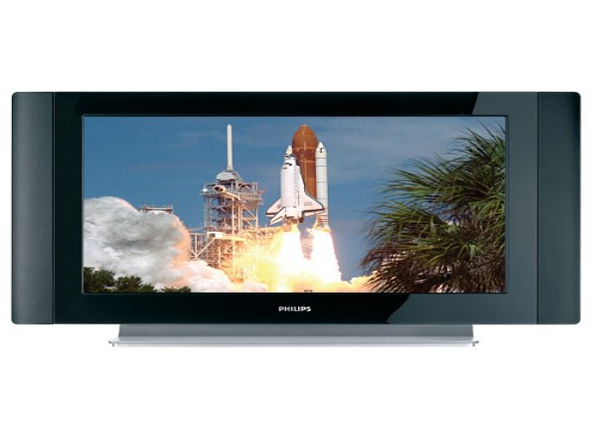

In [40]:
import requests
import numpy as np
from PIL import Image

image_path = './ecommerce-products/tv/11.jpg'
image = Image.open(image_path).convert('RGB')  
display(image.resize((596, 437)))
input_payload = encode_input(image)

In [41]:
def invoke_endpoint(endpoint_name, payload):
    import json
    
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name,
        Accept="application/json",
        ContentType="application/x-image",
        Body=payload
    )
    data = response["Body"].read()
    output = json.loads(data)
    return output

In [42]:
res = invoke_endpoint(endpoint_name, input_payload)
res

o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:19,009 [INFO ] epollEventLoopGroup-3-2 TS_METRICS - ts_inference_requests_total.Count:1.0|#model_name:model,model_version:default|#hostname:f5b31bb0006c,timestamp:1728216919
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:19,011 [INFO ] W-9007-model_1.0 org.pytorch.serve.wlm.WorkerThread - Looping backend response at: 1728216919011
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:19,013 [INFO ] W-9007-model_1.0-stdout MODEL_LOG - Backend received inference at: 1728216919
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:19,020 [INFO ] W-9007-model_1.0-stdout MODEL_LOG - Image size: (500, 500)
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:19,020 [INFO ] W-9007-model_1.0-stdout MODEL_LOG - Processing image of size: (500, 500)
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:19,021 [INFO ] W-9007-model_1.0-stdout MODEL_LOG - texts: [['a photo of a tv', 'a photo of a dog']]
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:19,513 [INFO ] W-9007-model_1.0-stdout MODEL_LOG - 

[['a photo of a tv', 0.61, [6.61, 104.85, 488.96, 390.46]]]

o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:52,414 [INFO ] pool-3-thread-1 TS_METRICS - CPUUtilization.Percent:0.0|#Level:Host|#hostname:f5b31bb0006c,timestamp:1728216952
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:52,415 [INFO ] pool-3-thread-1 TS_METRICS - DiskAvailable.Gigabytes:86.59526443481445|#Level:Host|#hostname:f5b31bb0006c,timestamp:1728216952
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:52,415 [INFO ] pool-3-thread-1 TS_METRICS - DiskUsage.Gigabytes:6.636112213134766|#Level:Host|#hostname:f5b31bb0006c,timestamp:1728216952
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:52,416 [INFO ] pool-3-thread-1 TS_METRICS - DiskUtilization.Percent:7.1|#Level:Host|#hostname:f5b31bb0006c,timestamp:1728216952
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:52,416 [INFO ] pool-3-thread-1 TS_METRICS - MemoryAvailable.Megabytes:25836.953125|#Level:Host|#hostname:f5b31bb0006c,timestamp:1728216952
o1k4xrqjdl-algo-1-fx9tz  | 2024-10-06T12:15:52,416 [INFO ] pool-3-thread-1 TS_METRICS - MemoryUsed.Megabyt

In [43]:
def delete_endpoint(client, endpoint_name):
    response = client.describe_endpoint(EndpointName=endpoint_name)
    EndpointConfigName = response['EndpointConfigName']
    
    response = client.describe_endpoint_config(EndpointConfigName=EndpointConfigName)
    model_name = response['ProductionVariants'][0]['ModelName']
    
    client.delete_model(ModelName=model_name)    
    client.delete_endpoint_config(EndpointConfigName=EndpointConfigName) 
    client.delete_endpoint(EndpointName=endpoint_name)
   
    print(f'--- Deleted model: {model_name}')
    print(f'--- Deleted endpoint_config: {EndpointConfigName}')     
    print(f'--- Deleted endpoint: {endpoint_name}')

In [44]:
delete_endpoint(sm_client, endpoint_name)
!sudo rm -rf /tmp/tmp*

Gracefully stopping... (press Ctrl+C again to force)
--- Deleted model: owlvit-base-patch32-model-2024-10-06-12-10-11
--- Deleted endpoint_config: owlvit-base-patch32-endpoint-config-2024-10-06-12-10-11
--- Deleted endpoint: owlvit-base-patch32-endpoint-2024-10-06-12-10-11


### Validating the container in SageMaker Endpoint

In [59]:
import boto3
import time

# Set to True to enable SageMaker to run locally
# local_mode = True
local_mode = False

if local_mode:
    from sagemaker.local import LocalSession
    instance_type = "local_gpu"
    sm_session = LocalSession()
    sm_session.config = {'local': {'local_code': True}}
    sm_client = sagemaker.local.LocalSagemakerClient()
    smr_client = sagemaker.local.LocalSagemakerRuntimeClient()
    model_data=f"file://{Path.cwd()}/{local_model_weight}"
    instance_count = 1
else:
    sm_session = sagemaker.Session()
    sm_client = boto3.client("sagemaker")
    smr_client = boto3.client("sagemaker-runtime")
    model_data = f"{model_data_url}/model.tar.gz"

ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
sm_model_name = f"{local_model_weight}-model-{ts}"
endpoint_config_name = f"{local_model_weight}-endpoint-config-{ts}"
endpoint_name = f"{local_model_weight}-endpoint-{ts}"
model_data

's3://sagemaker-us-west-2-490045531646/240929-deploy-owl-vit/compressed_model/model.tar.gz'

In [60]:
import json
texts = json.dumps([["a photo of a tv", "a photo of a dog"]])

env = {
    "threshold" : "0.1",
    "texts" : texts
}

container = {
    "Image": image_uri,
    "ModelDataUrl": model_data,
    "Environment": env
}

In [61]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
            "ServerlessConfig": {
                "MemorySizeInMB": 2048,
                "MaxConcurrency": 2,
                "ProvisionedConcurrency": 1,
            }
        }
    ],
)
print("Model Arn: " + create_model_response["ModelArn"])
print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Model Arn: arn:aws:sagemaker:us-west-2:490045531646:model/owlvit-base-patch32-model-2024-10-06-12-28-02
Endpoint Config Arn: arn:aws:sagemaker:us-west-2:490045531646:endpoint-config/owlvit-base-patch32-endpoint-config-2024-10-06-12-28-02


In [62]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-west-2:490045531646:endpoint/owlvit-base-patch32-endpoint-2024-10-06-12-28-02


In [63]:
from IPython.display import display, HTML
def make_console_link(region, endpoint_name, task='[SageMaker LLM Serving]'):
    endpoint_link = f'<b> {task} <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={region}#/endpoints/{endpoint_name}">Check Endpoint Status</a></b>'   
    return endpoint_link

endpoint_link = make_console_link(region, endpoint_name)
display(HTML(endpoint_link))

In [64]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(30)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:490045531646:endpoint/owlvit-base-patch32-endpoint-2024-10-06-12-28-02
Status: InService


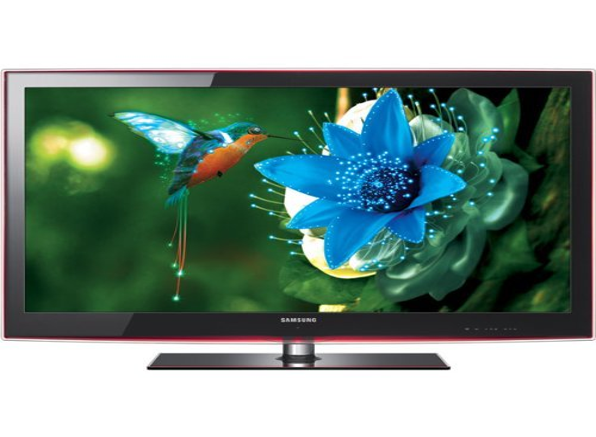

In [65]:
import requests
import numpy as np
from PIL import Image

image_path = './ecommerce-products/tv/1.jpg'
image = Image.open(image_path).convert('RGB')  
display(image.resize((596, 437)))
input_payload = encode_input(image)

In [69]:
%time
res = invoke_endpoint(endpoint_name, input_payload)
res

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 5.25 μs


[['a photo of a tv', 0.597, [2.59, 75.17, 499.33, 414.01]]]

### Clean up

In [57]:
def delete_endpoint(client, endpoint_name):
    response = client.describe_endpoint(EndpointName=endpoint_name)
    EndpointConfigName = response['EndpointConfigName']
    
    response = client.describe_endpoint_config(EndpointConfigName=EndpointConfigName)
    model_name = response['ProductionVariants'][0]['ModelName']
    
    client.delete_model(ModelName=model_name)    
    client.delete_endpoint_config(EndpointConfigName=EndpointConfigName) 
    client.delete_endpoint(EndpointName=endpoint_name)
   
    print(f'--- Deleted model: {model_name}')
    print(f'--- Deleted endpoint_config: {EndpointConfigName}')     
    print(f'--- Deleted endpoint: {endpoint_name}')

In [58]:
delete_endpoint(sm_client, endpoint_name)

--- Deleted model: owlvit-base-patch32-model-2024-10-06-12-18-01
--- Deleted endpoint_config: owlvit-base-patch32-endpoint-config-2024-10-06-12-18-01
--- Deleted endpoint: owlvit-base-patch32-endpoint-2024-10-06-12-18-01
